In [10]:
#install
import pybamm
import pybammeis
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
# Set seed
np.random.seed(0)

In [64]:
# Define a class containing the DFN model or PMe model with degradation mechanisms(SEI growth & lithium plating and particle cracking)
class simul():
    def __init__(self, profile, cycles):
        self.exp = profile

        self.model = pybamm.lithium_ion.DFN(
            {
            "thermal": "isothermal",
            "SEI": "solvent-diffusion limited",
            "SEI porosity change": "true",
            "lithium plating": "partially reversible",
            "lithium plating porosity change": "true",  # alias for "SEI porosity change"
            "particle mechanics": ("swelling and cracking","swelling only"),
            "SEI on cracks": "true",
                "loss of active material": "stress-driven",
                "calculate discharge energy": "true",  # for compatibility with older PyBaMM versionsg
            })
        
        self.aged_model = deepcopy(self.model)

        self.param = pybamm.ParameterValues("OKane2022")
        self.param.update({
            "Initial temperature [K]": 278.15, #change the temperature 
            "SEI growth activation energy [J.mol-1]": 37000.0,
            "Ambient temperature [K]": 293.15,},)

        # Discretization points
        self.var_pts = {
            "x_n": 5,
            "x_s": 5,
            "x_p": 5,
            "r_n": 8,
            "r_p": 8,
        }
        self.solver = pybamm.IDAKLUSolver(atol=1e-5, rtol=1e-5)
        self.cycle_number = cycles  # for  aging

        self.data = {} #filled after the simulation, used to evaluate fitness

    def run(self):
        solutions = []
        # Run 1 full charge/discharge/hold cycle at a time
        for cycle in range(1, self.cycle_number + 1):
            print(f"\n Running cycle {cycle}...")

            # Run the cycle using the aged model 
            sim = pybamm.Simulation(
                self.aged_model,
                parameter_values=self.param,
                experiment=self.exp,
                solver=self.solver,
                var_pts=self.var_pts,
            )
            sol = sim.solve(calc_esoh=True,initial_soc=1)
            if cycle in [1, self.cycle_number]:
                solutions.append(sol)
        
        # Extract relevant info to later evaluate the model
        self.data['SOH'] = solutions[1].summary_variables["Capacity [A.h]"][-1] / solutions[0].summary_variables["Capacity [A.h]"][-1]

        # Now let's get the time elapsed for a complete charge
        # Consider only the first one, greedy approach that mirrors the request
        self.data['time'] = solutions[0]["Time [s]"].entries[-1] - solutions[0]["Time [s]"].entries[0]

        # Compute energy loss during the charging process
        # Use numpy to calculate energy input and output
        current = solutions[0]["Current [A]"].entries
        voltage = solutions[0]["Voltage [V]"].entries
        time = solutions[0]["Time [s]"].entries

        # Calculate energy input using numpy dot product
        energy_input = np.dot(voltage, np.diff(time, prepend=0) * current) / 3600  # Convert to Wh

        # Calculate energy output
        final_capacity = solutions[0].summary_variables["Capacity [A.h]"][-1]
        final_voltage = voltage[-1]
        energy_output = final_capacity * final_voltage  # Energy stored in the battery (Wh)

        # Calculate the energy loss
        print(f'{energy_input} , {energy_output}')
        energy_loss = energy_input - energy_output

        # Store energy loss and efficiency in the data dictionary
        self.data['energy_loss'] = round(energy_loss, 4)
        self.data['efficiency'] = (energy_output / energy_input) * 100  # Charging efficiency in percentage

    def evaluate_fitness(profile=None):
        if profile.lower == 'fast charge':
            return

        if profile == 'sustainable':
            return

        if profile == 'long life':
            return 

        # Here profile can only be all day    
        return

In [65]:
# Define what is needed to do genetic algorithm to find best profiles
es = pybamm.Experiment([
    (
        "Discharge at 1C until 2.5 V",
        "Charge at 5 A until 4.2 V",
        "Hold at 4.2 V until C/100",
        "Rest for 30 minutes",
    )
],period="30 minutes",) #change this for good accuracy

test = simul(es, 4)
test.run()
print(test.data)


 Running cycle 1...

 Running cycle 2...

 Running cycle 3...

 Running cycle 4...
-1.8490286431347678 , 21.39381941408462
{'SOH': 1.0, 'time': 12045.055970127454, 'energy_loss': -23.2428, 'efficiency': -1157.0301787112617}


In [ ]:
profiles = ['fast charge', 'sustainable', 'long life', 'all day']
from math import sqrt

# Genetic stuff
def random_profile():

    a, b = 2, 5  # number of charges setted with a beta
    number_of_charge = int(max(1, np.ceil(6 * np.random.beta(a, b))))

    ampere_per_charge = [max(0.5, min(np.random.normal(0.5, 0.5), 2))]
    for i in range (1, number_of_charge):
        ampere_per_charge.append(max(ampere_per_charge[i-1] + 0.1, min(np.random.normal(ampere_per_charge[i-1], 0.5), 2)))
    
    times_per_charge = [max(15, min(np.random.normal(20, 10), 30)) for _ in range (number_of_charge)] #if the number of charge are 1, no time is used but only the until 4.2 V
    
    hold_cutoff = np.random.choice(["C/100", "C/50", "C/20"])

    s = ["Discharge at 1C until 2.5 V"]

    for i in range (number_of_range):


    for _ in range

[2.0, 4.0, 1, 3.0, 2.0, 2.0, 1, 2.0, 1, 1, 1, 3.0, 2.0, 1, 2.0, 2.0, 1, 4.0, 3.0, 2.0, 2.0, 1, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 4.0, 2.0, 3.0, 1, 1, 2.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 1, 3.0, 2.0, 2.0, 4.0, 3.0, 2.0, 2.0, 4.0, 1, 2.0, 2.0, 2.0, 1, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 1, 2.0, 1, 2.0, 2.0, 2.0, 1, 5.0, 2.0, 2.0, 3.0, 1, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 4.0, 3.0, 2.0, 4.0, 3.0, 1, 3.0, 2.0, 4.0, 1, 4.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0]


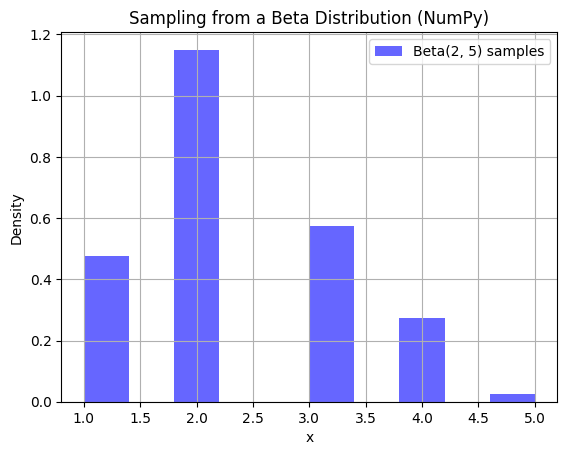

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parameters for the Beta distribution (α = a, β = b)
a, b = 2, 5  # you can change these
samples = [max(1, np.ceil(6 * np.random.beta(a, b))) for i in range (100)]
print(samples)
plt.hist(samples, density=True, color='blue', alpha=0.6, label=f'Beta({a}, {b}) samples')
plt.title('Sampling from a Beta Distribution (NumPy)')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show() 